# 08_Grunerlokka_MCLP_v1.0

## The Maximal Coverage Location Problem

Notebook adapted from [MCLP example](https://pysal.org/spopt/notebooks/mclp.html) in PySAL documentation.   
*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)


### MLCP Police Cars Scenario v1.0

Adapting the MCLP example from PySAL documentation to a police cars scenario in a small road network with Grunerlokka, Oslo, Norway as  an example.   
The goal is to find the best locations for 4 police cars to maximize the coverage of crime events in the area.


| Categories           | Original PySAL Example    | Police cars example v1.0 **(this notebook)**                          |
|----------------------|----------------------|---------------------------------------|
| **Objective function**| Maximize nodes covered  | Maximize **weighted sum** of nodes covered  |
| **Clients (events)**          | Number = 100          | 77, but varies with each simulation                         |                                 |
|                      | Placement = randomly generated with `simulated_geo_points()` | Placement = simulated based on population in 250x250m gridcells + randomness |
| **Client weights**   | Random weight in range [1,12] using `np.random.randint()` | Weighted according to distance to one crime hotspot. $w_i = 1/dist_i^2$ |
| **Facilities (cars)**       | Number = 4/10 candidates | Number = 4/10 candidates          |
|                      | Service radius = 1000m | Service radius = 800m              |
|                      | Placement = randomly generated with `simulated_geo_points()` | Placement = manually picked 10 promising candidate points in OSM |




---

The objective of the LSCP is to minimize the number of candidate facility sites in a maximum service standard but therein arises another problem: the budget. Sometimes it requires many facility sites to achieve complete coverage, and there are circumstances when the resources are not available. Therefore, determining how much coverage can be achieved considering an exact number of facilities is highly beneficial. The MCLP class solves this problem: _Maximize the amount of demand covered within a maximal service distance or time standard by locating a fixed number of facilities_.

**MCLP in math notation:**

**Maximize:**
- $ \sum_{i \in I} a_i X_i $

**Subject to:**
- $ \sum_{j \in N_i} Y_j \geq X_i \quad \forall i \in I $
- $ \sum_{j \in J} Y_j = p $
- $ X_i \in \{0, 1\} \quad \forall i \in I $
- $ Y_j \in \{0, 1\} \quad \forall j \in J $

**Where:**

- $i$ = index referencing nodes of the network as demand
- $j$ = index referencing nodes of the network as potential facility sites
- $S$ = maximal acceptable service distance or time standard
- $d_{i,j}$ = shortest distance or travel time between nodes $i$ and $j$
- $N_i$ = $j | d_{ij} \leq S$ 
- $p$ = number of facilities to be located
- $Y_j$ =
  - 1, if a facility is located at node $j$
  - 0, otherwise
- $X_i$ =
  - 1, if demand $i$ is covered within a service standard
  - 0, otherwise

  
_This excerpt above is adapted from Church and Murray (2018)._

Three MCLP instances are solved while varying parameters:

* `MCLP.from_cost_matrix()` with network distance as the metric
* `MCLP.from_geodataframe()` with euclidean distance as the metric
* `MCLP.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

In [8]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-03-06T21:03:44.529369+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.0

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [9]:
# imports
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
from shapely.ops import unary_union
import pulp
from spopt.locate import MCLP, simulated_geo_points # import the MCLP model

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline

%watermark -w
%watermark -iv

Watermark: 2.4.3

pulp      : 2.7.0
networkx  : 3.2.1
matplotlib: 3.8.0
spaghetti : 1.7.4
numpy     : 1.24.4
osmnx     : 1.7.1
geopandas : 0.14.0
pandas    : 2.1.2



## 1. Loading Road network - using OSMnx and NetworkX
Loading a small road network of Grünerløkka for testing.

In [10]:
# Road network file paths
gruner_filepath = "../data/GrunerServiceImputed.graphml" # GraphML format (with speed and travel time)

# If want to fetch network directly from OSM
# gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service")

In [11]:
# load the network as NetworkX MultiDiGraph object - using osmnx (Recommended)
gruner_graph = ox.load_graphml(gruner_filepath) # originally in WGS84 (EPSG:4326)
gruner_graph = ox.projection.project_graph(gruner_graph, to_crs='EPSG:32633') # project to UTM zone 33N
print(f"type of gruner_graph: {type(gruner_graph)}")
print(f"crs of gruner_graph:  {gruner_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(gruner_graph, node_size=4, edge_linewidth=0.5, edge_color="w")

type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
crs of gruner_graph:  EPSG:32633


Successfully imported road network of Grünerløkka, Oslo, Norway.  
Converted Coordinate system (CRS) to UTM 33N (EPSG:25833).

In [12]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
gruner_gdf_nodes, gruner_gdf_edges = ox.graph_to_gdfs(gruner_graph)
print(f"type of gruner_gdf_nodes:{type(gruner_gdf_nodes)}")
# gruner_gdf_nodes.head()

type of gruner_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


In [13]:
streets = gruner_gdf_edges
print(type(streets))
# streets.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


## 2. Load population data
Loading population data in 250x250m grid cells for Oslo, Norway.   
Format: GeoJSON  
CRS: WGS84 (EPSG:4326).

Grünerløkka population statistics:
 count     100.000000
mean      836.890000
std       565.712296
min         1.000000
25%       349.250000
50%       791.000000
75%      1278.250000
max      1989.000000
Name: population, dtype: float64
<class 'geopandas.geodataframe.GeoDataFrame'>


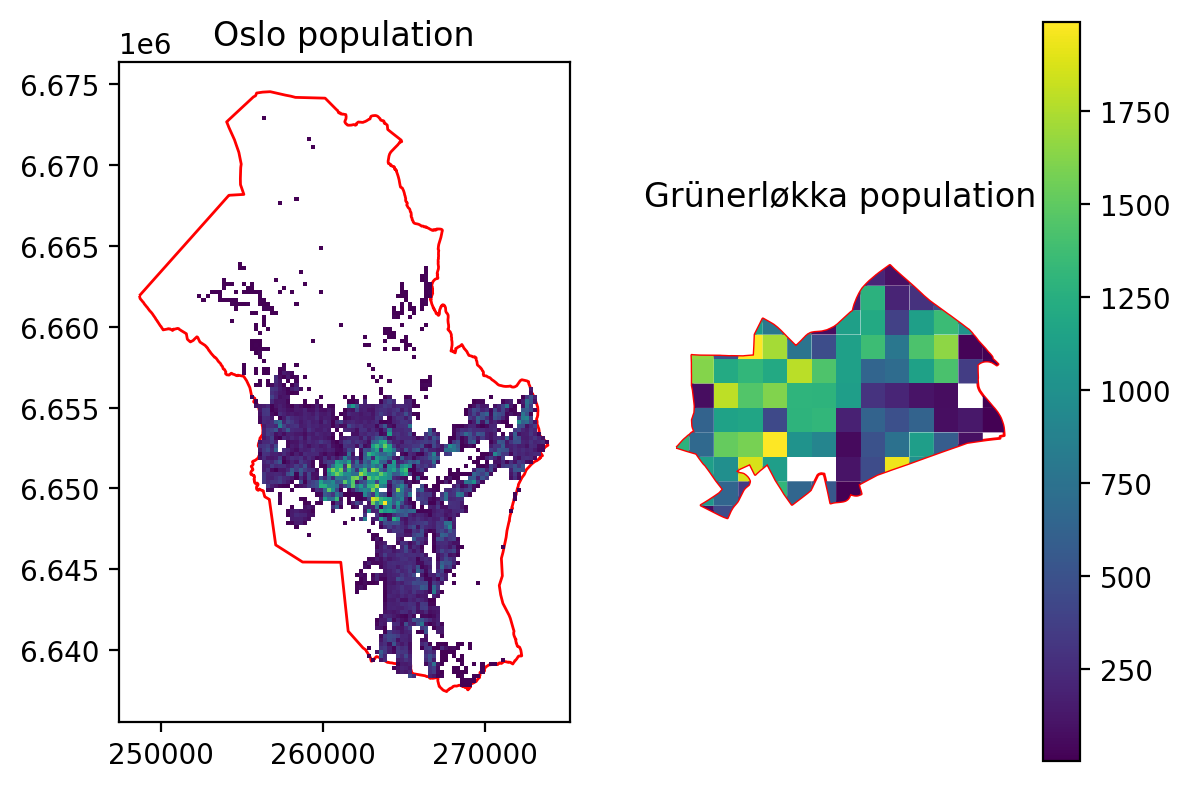

In [14]:
# load geopandas dataframe of population data
oslo_population_geojson = "..data\oslo_population_dataset\Oslo_pop2023_250m_wgs84_epsg4326_geojson\oslo_pop2023_250m_wgs84_epsg4326.geojson"
oslo_population = gpd.read_file(oslo_population_geojson)
oslo_population.to_crs(crs='EPSG:32633', inplace=True) # convert from WGS84 (EPSG:4326) to UTM zone 33N (EPSG:32633)
oslo_population.columns = ['id', 'population', 'geometry'] # rename column names

# Clip the population data using the Grünerløkka footprint from OSM
oslo_footprint_osm = ox.geocode_to_gdf("Oslo, Norway")
gruner_footprint_osm = ox.geocode_to_gdf("Grünerløkka, Norway")
gruner_footprint_osm = gruner_footprint_osm.to_crs(epsg=32633) # convert from WGS84 (EPSG:4326) to UTM zone 33N (EPSG:32633)
oslo_footprint_osm = oslo_footprint_osm.to_crs(epsg=32633) # convert from WGS84 (EPSG:4326) to UTM zone 33N (EPSG:32633)
gruner_population = gpd.clip(oslo_population, gruner_footprint_osm)

# print statistics of population data
print("Grünerløkka population statistics:\n", gruner_population['population'].describe())
print(type(gruner_population))
gruner_population.head()

# Visualize population data of Oslo and Grünerløkka
fig, axs = plt.subplots(1, 2)
oslo_footprint_osm.plot(ax=axs[0], facecolor="none", edgecolor="r")   # Oslo footprint
gruner_footprint_osm.plot(ax=axs[1], facecolor="none", edgecolor="r") # Grünerløkka footprint
oslo_population.plot(column='population', cmap='viridis', ax=axs[0])  # Oslo population
gruner_population.plot(column='population', cmap='viridis', legend=True, ax=axs[1]) # Grünerløkka population
axs[0].set_title('Oslo population')
axs[1].set_title('Grünerløkka population')
axs[1].axis('off'); plt.show()

After inspection, we see the population ranges from 1 to 1989 in the 250x250m grid cells, in Grünerløkka.

## 3 Simulate denmand nodes (events)
Task: simulate denmand nodes (events) the police cars have to respond to based on the population data (250x250m gridcells).  
For each gridcell, simulated events are generated as follows:
$$ X_i = a * population_i + b * randomfactor $$

where $X_i$ is the number of simulated events generated in gridcell i, $population_i$ is the population in gridcell i, and $randomfactor$ is a normally distributed random variable ($N(0,1)$), with mean 0 and standard deviation 1 . a and b are scaling constants to adjust the number of simulated events.

In [15]:
from shapely.geometry import Point
from shapely.ops import nearest_points

# Define scaling constants
population_multiplier = 0.001
randomness_multiplier = 0.1

# Normal distribution parameters
mu = 0  # mean
sigma = 1  # standard deviation

# Function to generate random points (events) within a polygon (gridcell)
def generate_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)) # uniform distribution in each gridcell
        if random_point.within(poly):
            points.append(random_point)
    return points

In [16]:
# Simulate points based on population and generate them within each grid cell
simulated_event_points = []
for _, row in gruner_population.iterrows():
    num_points = np.round(population_multiplier * row['population'] + randomness_multiplier * np.random.normal(mu, sigma))
    num_points = max(int(num_points), 0)  # Ensure non-negative integer
    if num_points > 0:
        simulated_event_points += generate_random_points(row['geometry'], num_points)

# print number of points and add to GeoDataFrame
print(f"Number of simulated event points: {len(simulated_event_points)} (OBS: will vary due to randomness in the simulation process.)")
event_points_gdf = gpd.GeoDataFrame(geometry=simulated_event_points, crs=gruner_population.crs)
event_points_gdf.head()

Number of simulated event points: 78 (OBS: will vary due to randomness in the simulation process.)


geometry
0  POINT (264256.630 6649622.204)
1  POINT (264418.042 6649863.378)
2  POINT (264511.990 6649914.861)
3  POINT (264646.185 6649998.935)
4  POINT (264778.668 6649952.944)

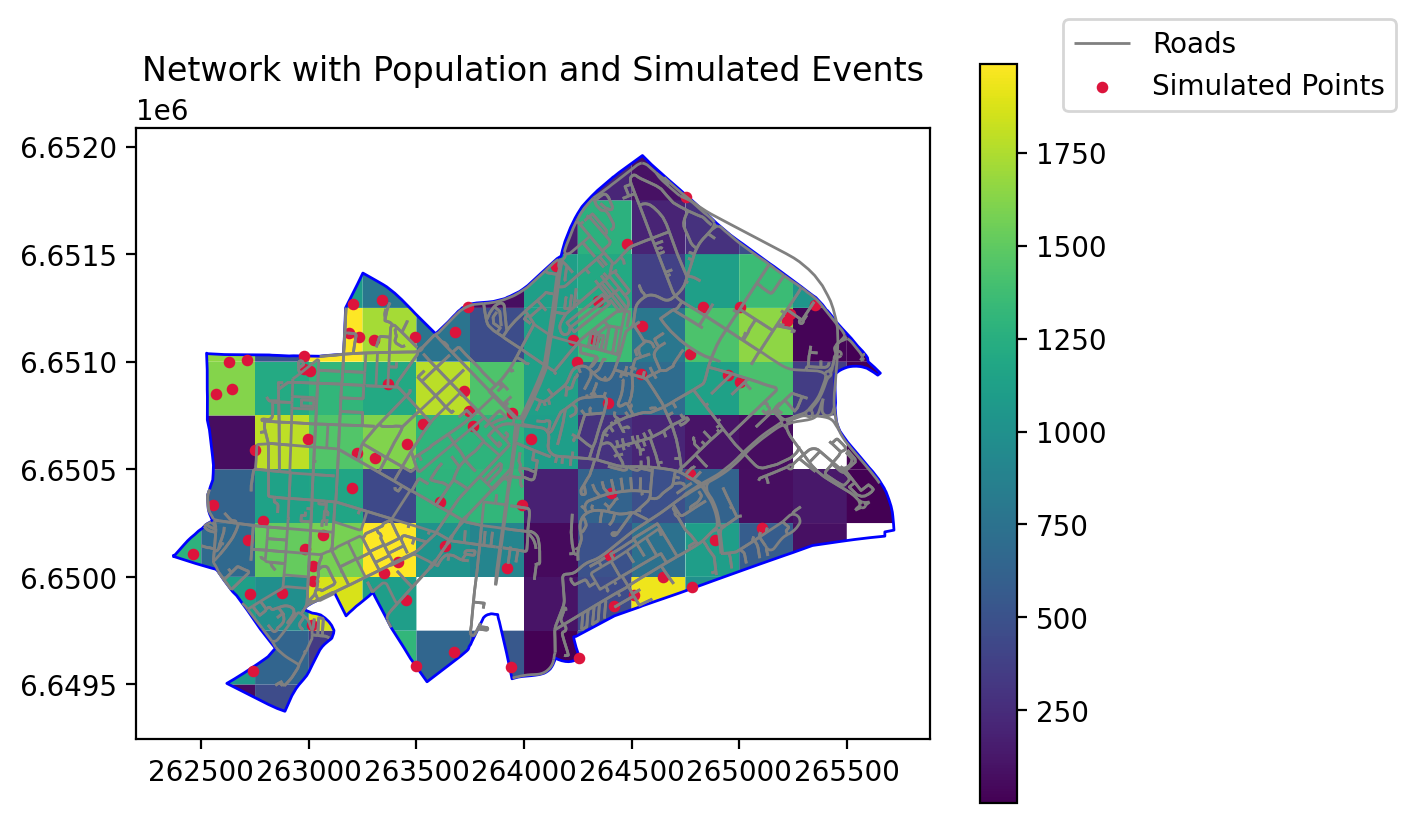

In [17]:
# Plot the road network
fig, ax = plt.subplots()
streets.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
gruner_population.plot(ax=ax, column='population', cmap='viridis', legend=True)
gruner_footprint_osm.plot(ax=ax, facecolor="none", edgecolor="b") # Grünerløkka footprint
event_points_gdf.plot(ax=ax, color='crimson', markersize=10, label='Simulated Points') # Simulated points
ax.set_title('Network with Population and Simulated Events'); 
plt.legend(loc="upper left", bbox_to_anchor=(1.15, 1.2)); plt.show()

## 4 Add weights to demand nodes (events)
Weight is added to each demand node (event) based on the distance to one manually defined crime hotspot (left edge in this case). The weight is calculated as: $$ w_i = 1/dist_i^2 $$
Where $w_i$ is the weight of demand node i, and $dist_i$ is the distance from demand node i to the crime hotspot. The weight is inversely proportional to the square of the distance to the crime hotspot.  
(TODO: add more stable weights based on proximity intervals)

In [18]:
from pyproj import Transformer

# Using Transformer for coordinate conversion
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)
crime_hotspot_location_wgs84 = (59.9211733, 10.7531202) # crime hotspot location in WGS84 coordinates (latitude, longitude)
x, y = transformer.transform(crime_hotspot_location_wgs84[1], crime_hotspot_location_wgs84[0])
crime_hotspot_location_utm = Point(x, y) # crime hotspot location in UTM 33N coordinates

# Function to calculate Euclidean distance to the crime hotspot
def calculate_distance_to_hotspot(point_utm, hotspot):
    return point_utm.distance(hotspot)

# Scaling factor to adjusts the weights to desired range
scaling_factor = 150000  # Adjust as needed

# Calculate weights for each point
event_points_gdf['weights'] = event_points_gdf['geometry'].apply(
lambda x: scaling_factor / (calculate_distance_to_hotspot(x, crime_hotspot_location_utm))**2 )
# event_points_gdf['weights'] = event_points_gdf['geometry'].apply(
#     lambda x: (scaling_factor / (calculate_distance_to_hotspot(x, crime_hotspot_location_utm))**2) ) * 0 # TEST SETTING: WEIGHT = 0

# Shift the weights so the minimum is 1
min_weight = event_points_gdf['weights'].min()
adjusted_weights = event_points_gdf['weights'] - min_weight + 1
event_points_gdf['weights'] = adjusted_weights

# Print the first 3 points with weights and the weight statistics
print(event_points_gdf.head(3))
print("\nWeight statistics:\n", event_points_gdf['weights'].describe())

                         geometry   weights
0  POINT (264256.630 6649622.204)  1.033006
1  POINT (264418.042 6649863.378)  1.028309
2  POINT (264511.990 6649914.861)  1.024336

Weight statistics:
 count    78.000000
mean      1.657727
std       2.299227
min       1.000000
25%       1.024426
50%       1.087157
75%       1.264192
max      17.367990
Name: weights, dtype: float64


In this simulation, the weights are in the range [0-30].   
So, the point closest to the crime hotspot has a weight of 30, and the point farthest from the crime hotspot has a weight of 1. Most points have a low weight close to 1.0 unless they are close to the crime hotspot.

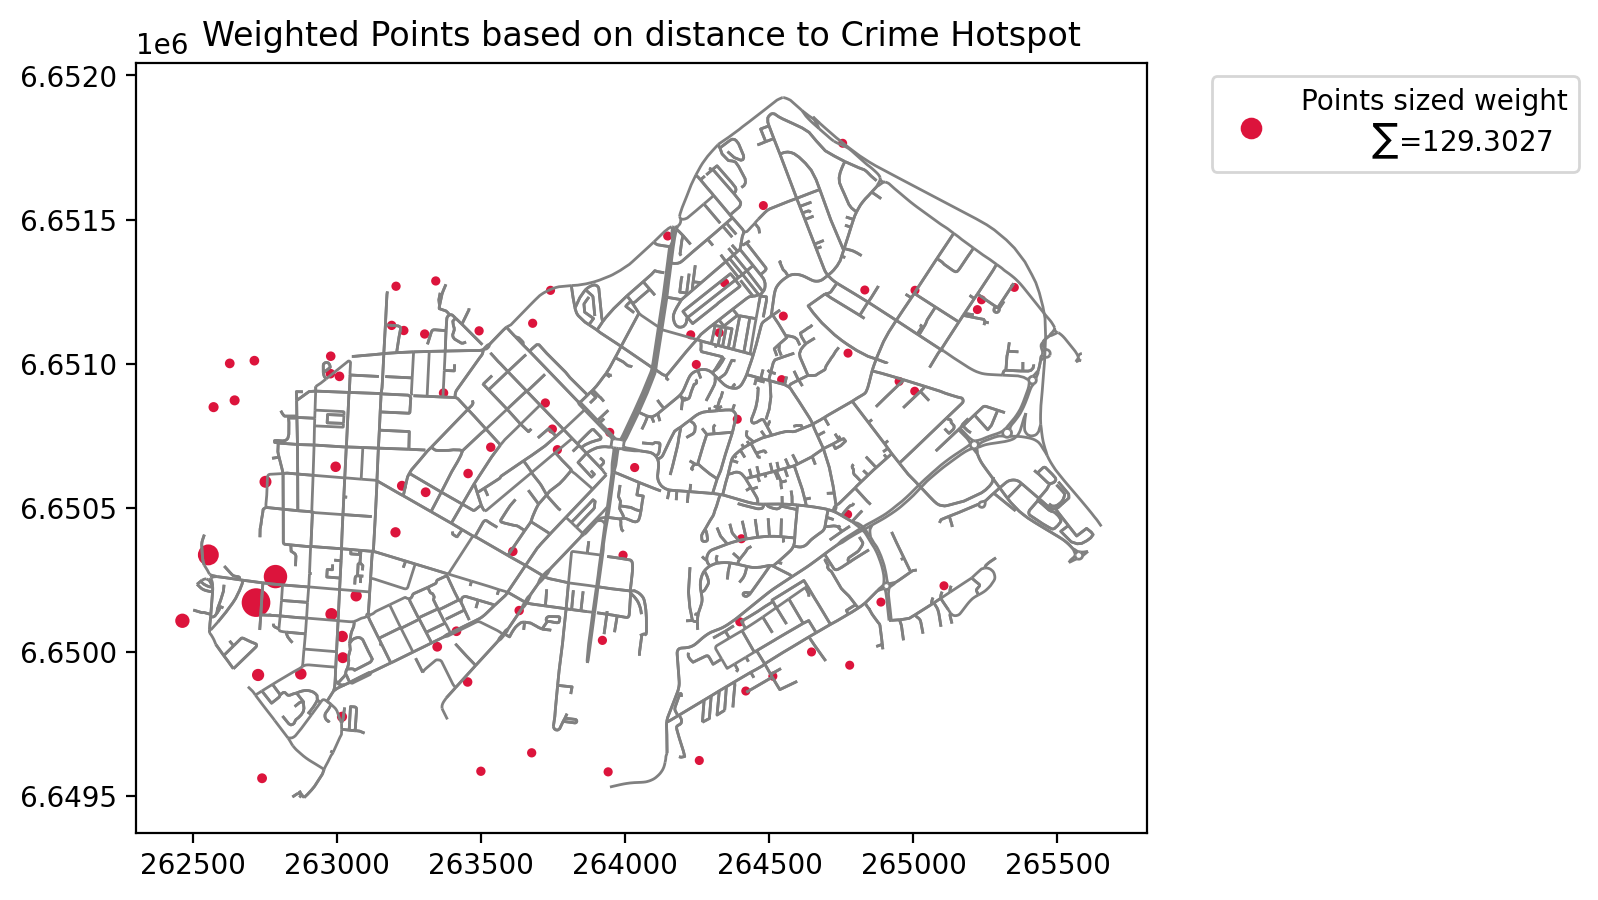

In [19]:
# Plot the road network with weighted points
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed
streets.plot(ax=ax, linewidth=1, edgecolor='gray')  # Plot edges; adjust style as desired
event_points_gdf.plot(ax=ax, 
                        color='crimson', 
                        # label='Weighted Points',
                        label=f"Points sized weight\n\t$\sum$={round(event_points_gdf['weights'].sum(),4)}",
                        markersize=event_points_gdf['weights']  * 5)  # Plot points; adjust color and size as desired
ax.set_title('Weighted Points based on distance to Crime Hotspot')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1)); plt.show()

The Crime hotspot is defined on the left side of the map, and the weights are calculated based on the distance to this point.  
The weight associated to each point determine the size of the marker in the plot.

## 5 Add facilities (police car locations)
Current approach: Manually pick 10 decent locations from OpenStreetMap.

In [20]:
# Police car locations - manually picked from OpenStreetMap (in WGS84 coordinates)
car_locations = [
    (10.7612002, 59.9223233),
    (10.7611394, 59.9254773),
    (10.7666671, 59.9199786),
    (10.7765093, 59.9260426),
    (10.7780040, 59.9285290),
    (10.7885055, 59.9317113),
    (10.7935162, 59.9261466),
    (10.7892110, 59.9244527),
    (10.7835711, 59.9206872),
    (10.7828007, 59.9247590) ]

car_locations_utm = []
for location in car_locations:
    x, y = transformer.transform(location[0], location[1])
    # Create a Point object for each transformed location and add to the list
    car_locations_utm.append(Point(x, y))

# Convert locations to a GeoDataFrame
police_car_gdf = gpd.GeoDataFrame({'geometry': [Point(xy) for xy in car_locations_utm]}, crs="EPSG:32633")
police_car_gdf.head()

geometry
0  POINT (263123.189 6650348.109)
1  POINT (263142.292 6650699.097)
2  POINT (263411.715 6650067.780)
3  POINT (264004.367 6650707.032)
4  POINT (264105.476 6650978.227)

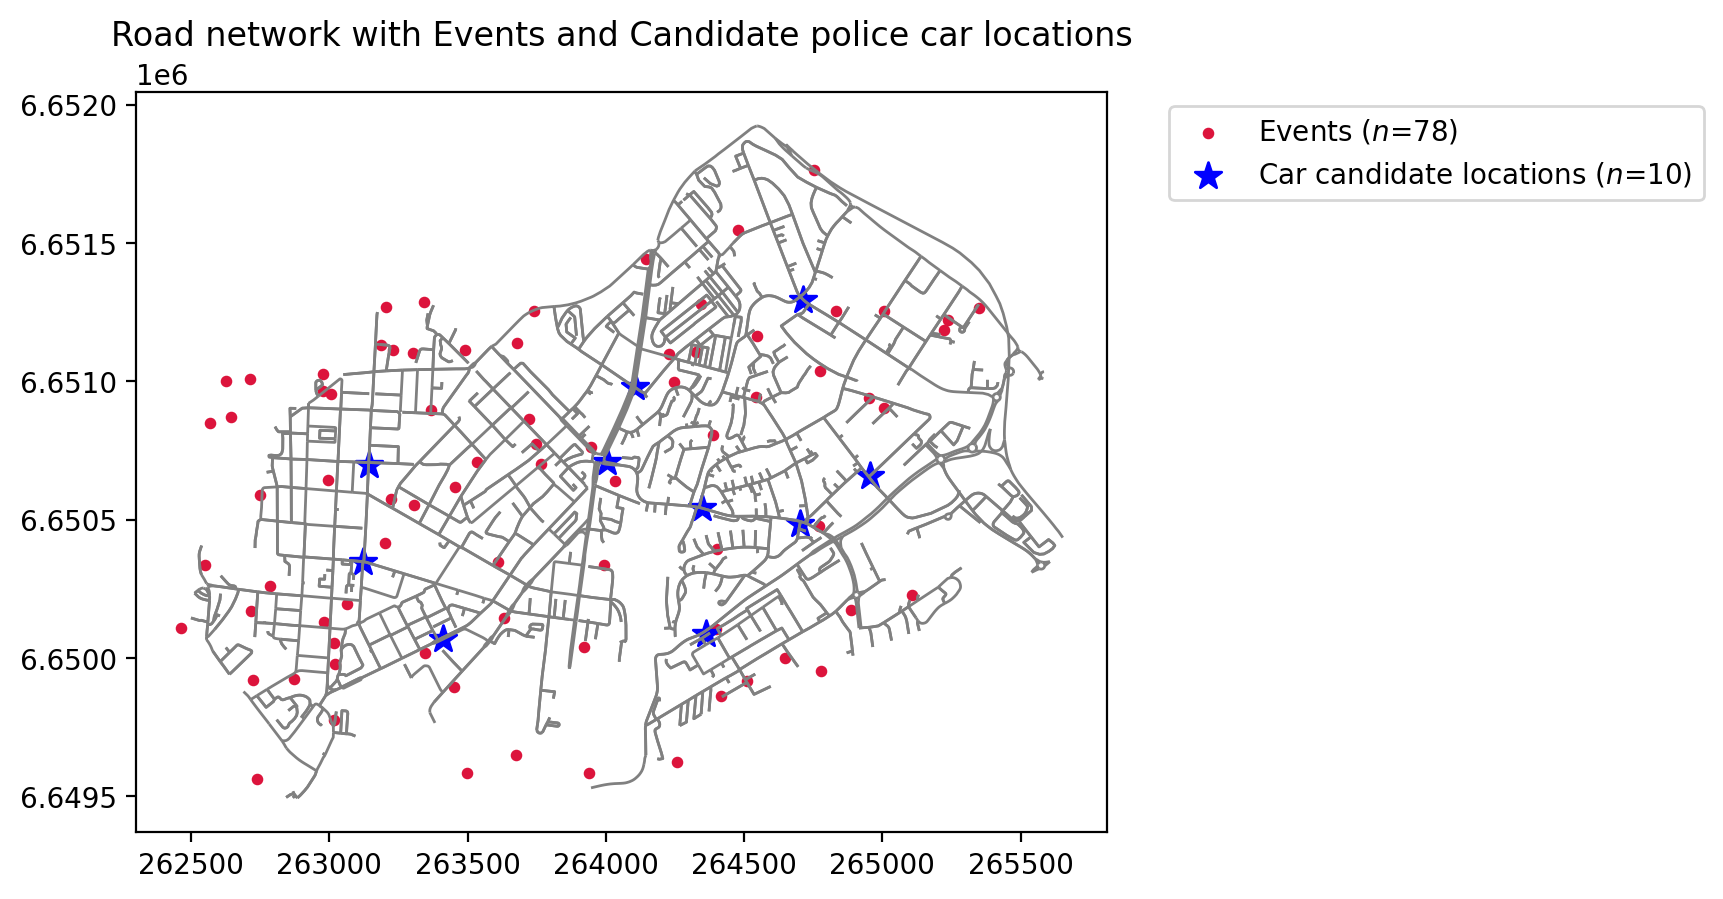

In [21]:
# Plot the road network
fig, ax = plt.subplots()
gruner_gdf_edges.plot(ax=ax, linewidth=1, edgecolor='gray')
event_points_gdf.plot(ax=ax, color='crimson', markersize=10, label=f'Events ($n$={len(simulated_event_points)})')
police_car_gdf.plot(ax=ax, color='blue', marker='*', markersize=100, label=f'Car candidate locations ($n$={len(car_locations)})')
ax.set_title('Road network with Events and Candidate police car locations')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1)); plt.show()

## 2. PySAL spopt and spaghetti

Preparing network for optimization.

Since the model needs a cost matrix (distance, time, etc.) we should define some variables. First we will assign some the number of clients and facility locations, then the maximum service radius, followed by random seeds in order to reproduce the results. Finally, the solver, assigned below as `pulp.COIN_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface, such as Gurobi or CPLEX, see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [22]:
# quantity demand points (events)
CLIENT_COUNT = len(simulated_event_points) # simulated based on population, crime, randomness

# quantity facilities (police cars)
FACILITY_COUNT = 10

# maximum service radius (in distance units)
SERVICE_RADIUS = 800 # in meters

# number of candidate facilities in optimal solution
P_FACILITIES = 4

# set the solver
# solver = pulp.COIN_CMD(msg=False, warmStart=True) # I don't have this solver
solver = pulp.GLPK_CMD(msg=False) # does not support warm start?

## Assign simulated points network locations

The simulated client and facility points do not adhere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [23]:
# transforming my network into a spaghetti network
ntw = spaghetti.Network(in_data=streets)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(event_points_gdf, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(police_car_gdf, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)


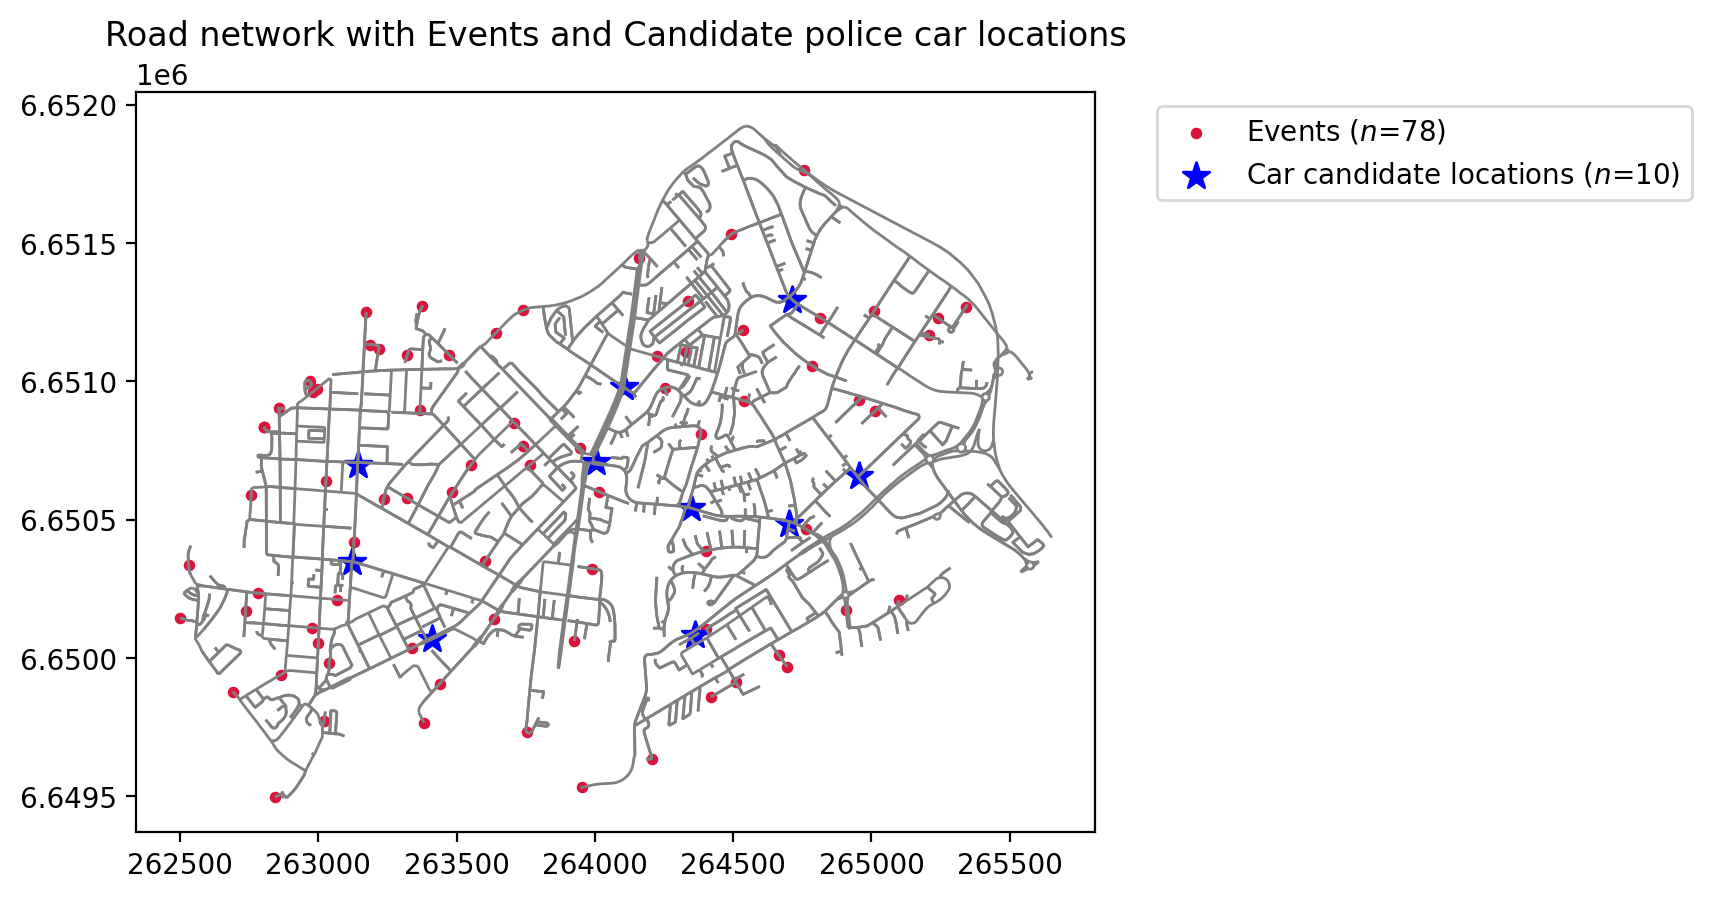

In [24]:
# Plot the road network
fig, ax = plt.subplots()
gruner_gdf_edges.plot(ax=ax, linewidth=1, edgecolor='gray')
clients_snapped.plot(ax=ax, color='crimson', markersize=10, label=f'Events ($n$={len(simulated_event_points)})')
facilities_snapped.plot(ax=ax, color='blue', marker='*', markersize=100, label=f'Car candidate locations ($n$={len(car_locations)})')
ax.set_title('Road network with Events and Candidate police car locations')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1)); plt.show()

Now the plot seems more organized as the points occupy network space.

## Calculating the (network distance) cost matrix

In [25]:
%%time
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
    n_processes="all"
)
print("Shape of cost matrix (events, facilities):", cost_matrix.shape)

Shape of cost matrix (events, facilities): (78, 10)
CPU times: total: 19.9 s
Wall time: 43.8 s


The expected result here is a network distance between clients and facilities points, in our case a 2D Ax10 array. Where A is the number of simulated clients (events) and 10 is the number of simulated facilities (police cars).

In [26]:
cost_matrix[:3,:]

array([[3199.47582252, 3142.24920202, 2960.0126586 , 1951.09351689,
        2253.16489942, 2400.74795125, 1568.52705884, 1307.84282233,
         750.64790626, 1508.94983669],
       [3056.32766342, 2999.10104293, 2816.8644995 , 1807.94535779,
        2086.0350146 , 2053.57089832, 1221.35000592, 1011.78196001,
         403.47085334, 1365.80167759],
       [2950.64596316, 2893.41934266, 2711.18279924, 1702.26365753,
        1980.35331433, 1947.88919806, 1115.66830565,  906.10025975,
         297.78915307, 1260.11997733]])

In [27]:
cost_matrix[-3:,:]

array([[2188.97877584, 2120.39654232, 1949.51561192,  958.90987239,
         656.83849336,  800.52374904, 1225.08430056, 1136.74138006,
        2176.43975354, 1244.56712435],
       [2278.03689366, 1970.49873097, 2039.86170168, 1049.25596215,
         747.18458312,  415.1987073 , 1287.50793408, 1309.28013506,
        2348.97850855, 1417.10587935],
       [2682.44842623, 2374.91026354, 2663.9802983 , 1673.37455877,
        1371.30317974,  847.56533546, 1719.87456224, 1947.28378376,
        2986.98215725, 2055.10952805]])

With ``MCLP.from_cost_matrix`` we model the MCLP to cover as much demand as possible with $p$ facility points within `SERVICE_RADIUS` distance units using the network distance cost matrix calculated above.

In [28]:
client_weights = event_points_gdf["weights"]
mclp_from_cm = MCLP.from_cost_matrix(
    cost_matrix,
    client_weights,
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    name="MCLP-network-distance"
)

The expected result is a solved instance of `MCLP`.

In [29]:
mclp_from_cm = mclp_from_cm.solve(solver)
mclp_from_cm

How much coverage is observed?

In [30]:
print(f"{mclp_from_cm.perc_cov}% coverage is observed")

73.07692307692308% coverage is observed


Define the decision variable names used for mapping later.

In [31]:
facility_points = facilities_snapped ### REPLACING WITH MY FACILITIES (CARS) ###
client_points = clients_snapped      ### REPLACING WITH MY CLIENTS (EVENTS) ###


facility_points["dv"] = mclp_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facilities_snapped["dv"] = facility_points["dv"]
facility_points

geometry  dv
0  POINT (263123.189 6650348.109)  y0
1  POINT (263142.292 6650699.097)  y1
2  POINT (263411.715 6650067.780)  y2
3  POINT (264004.367 6650707.032)  y3
4  POINT (264105.476 6650978.227)  y4
5  POINT (264714.250 6651294.748)  y5
6  POINT (264954.542 6650658.046)  y6
7  POINT (264702.194 6650484.962)  y7
8  POINT (264363.620 6650081.543)  y8
9  POINT (264346.484 6650541.846)  y9

## Calculating euclidean distance from a `GeoDataFrame`

With ``MCLP.from_geodataframe`` we model the MCLP to cover as much demand as possible with $p$ facility points within `SERVICE_RADIUS` distance units using geodataframes to calculate a euclidean distance cost matrix.

Next we will solve the MCLP considering all 10 candidate locations for potential selection.

In [32]:
distance_metric = "euclidean"
clients_snapped["weights"] = event_points_gdf["weights"]
mclp_from_gdf = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"MCLP-{distance_metric}-distance"
)

In [33]:
mclp_from_gdf = mclp_from_gdf.solve(solver)
print(f"{mclp_from_gdf.perc_cov}% coverage is observed")

97.43589743589743% coverage is observed


However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_0$, $y_1$, and $y_3$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [34]:
facility_points["predefined_loc"] = 0
facility_points.loc[(0,1,2), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

geometry  dv  predefined_loc
0  POINT (263123.189 6650348.109)  y0               1
1  POINT (263142.292 6650699.097)  y1               1
2  POINT (263411.715 6650067.780)  y2               1
3  POINT (264004.367 6650707.032)  y3               0
4  POINT (264105.476 6650978.227)  y4               0
5  POINT (264714.250 6651294.748)  y5               0
6  POINT (264954.542 6650658.046)  y6               0
7  POINT (264702.194 6650484.962)  y7               0
8  POINT (264363.620 6650081.543)  y8               0
9  POINT (264346.484 6650541.846)  y9               0

In [35]:
mclp_from_gdf_pre = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric = distance_metric,
    predefined_facility_col="predefined_loc",
    name=f"MCLP-euclidean-distance-predefined"
)

In [36]:
mclp_from_gdf_pre = mclp_from_gdf_pre.solve(solver)
print(f"{mclp_from_gdf_pre.perc_cov}% coverage is observed")

84.61538461538461% coverage is observed


## Plotting the results

The two cells below describe the plotting of the results. For each method from the `MCLP` class (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Demand points covered by more than one facility are displayed in overlapping concentric circles.

In [37]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [38]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, gpd.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom
    
    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]
    
    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("MCLP"):
            c = "r"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="orange", marker="*", markersize=200, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="orange", markeredgecolor="orange")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))
    
    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = gpd.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p
    
    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

### MCLP built from cost matrix (network distance)

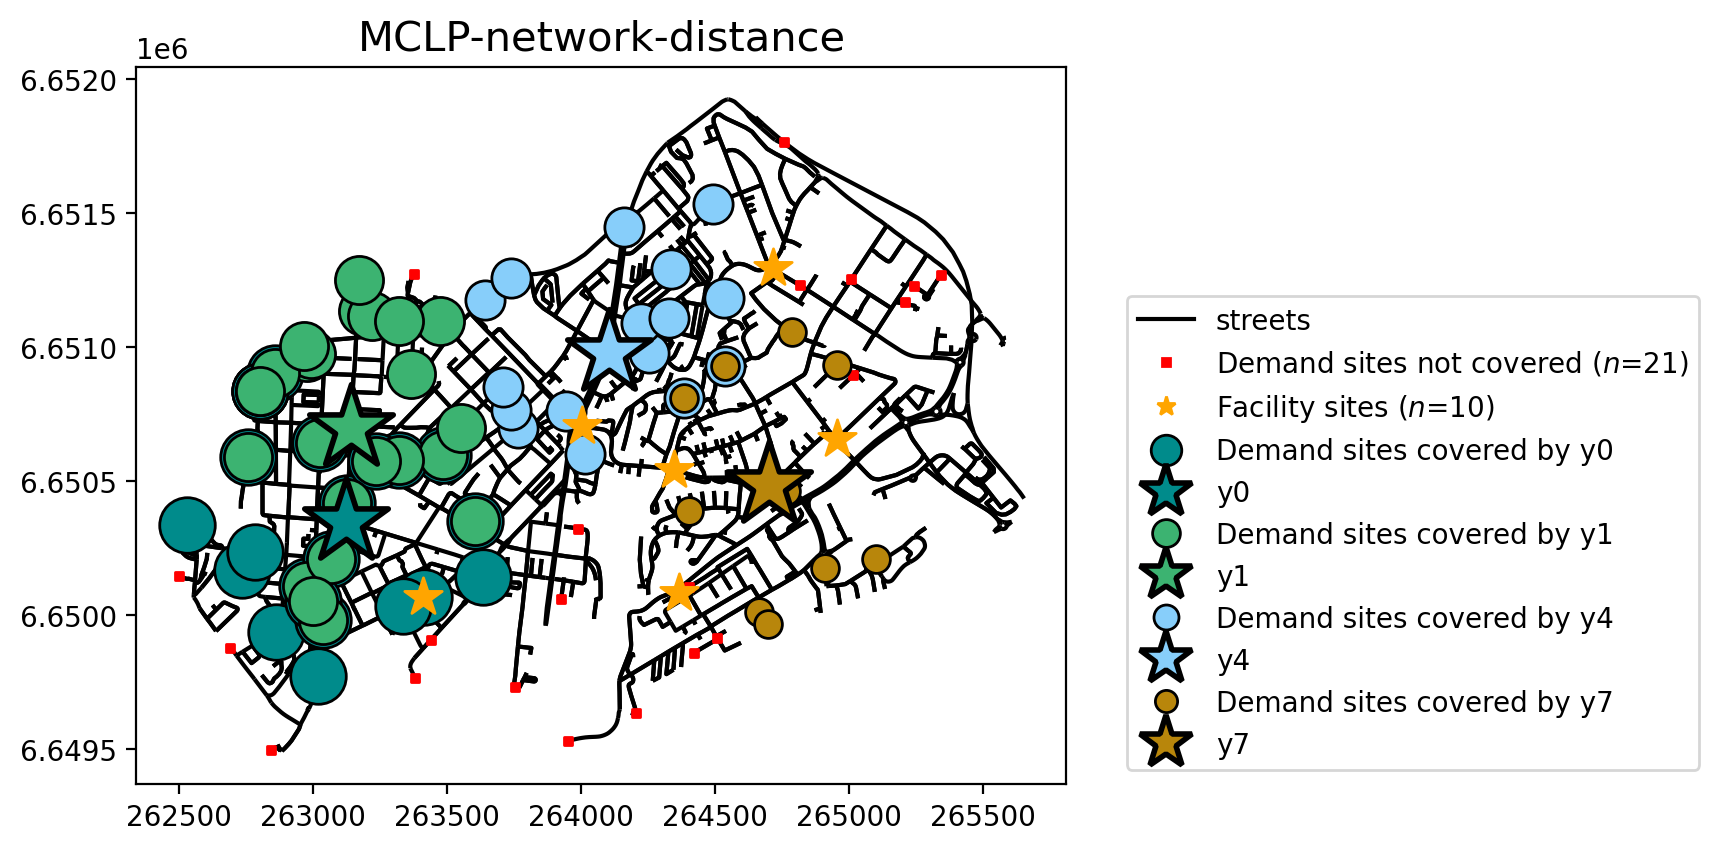

In [39]:
plot_results(mclp_from_cm, P_FACILITIES, facility_points, clis=client_points)

### MCLP built from geodataframes (euclidean distance)

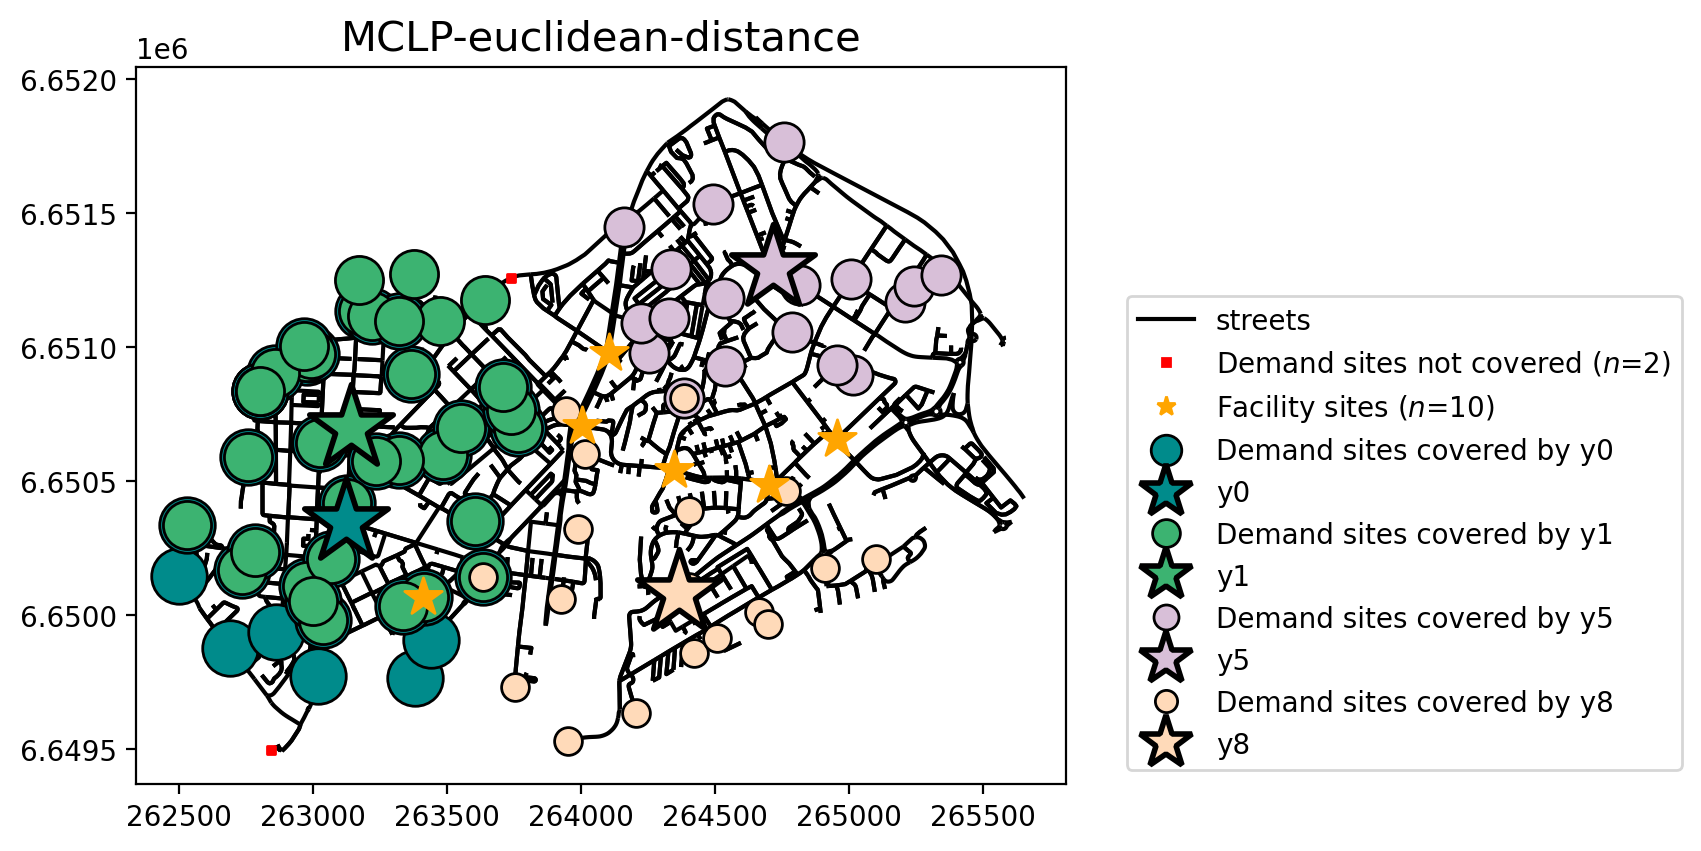

In [40]:
plot_results(mclp_from_gdf, P_FACILITIES, facility_points, clis=client_points)

You may notice that the model results are similar, yet different. This is expected as the distances between facility and demand points are calculated with different metrics (network vs. euclidean distance).

### MCLP with preselected facilities (euclidean distance)

Finally, let's visualize the results of the MCLP when stipulating that facilities $y_0$, $y_1$, and $y_3$ must be included in the final selection.

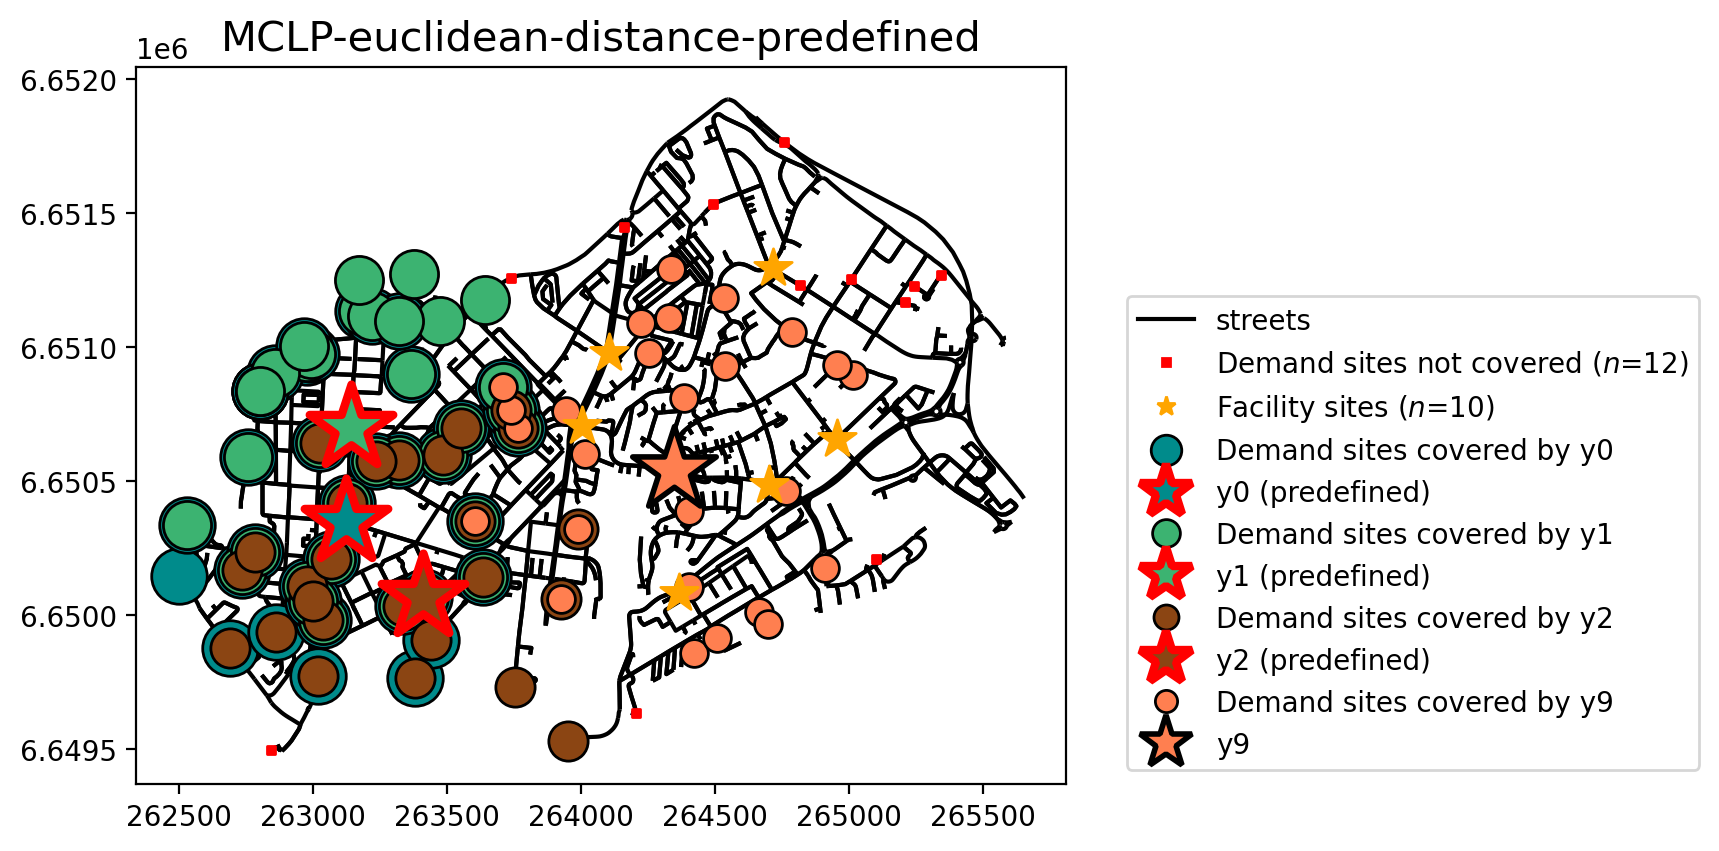

In [41]:
plot_results(mclp_from_gdf_pre, P_FACILITIES, facility_points, clis=client_points)

Here, the differences is explained by the preselected facilities $y_0$, $y_1$ and $y_3$. So, the MCLP model chooses the facility $y_4$ to maximize the coverage given the client points.

-----------------------------------

## Comparing solution from varied metrics

73.07692307692308% coverage is observed for MCLP network distance
97.43589743589743% coverage is observed for MCLP euclidean distance
84.61538461538461% coverage is observed for MCLP euclidean distance with forced predefined locations


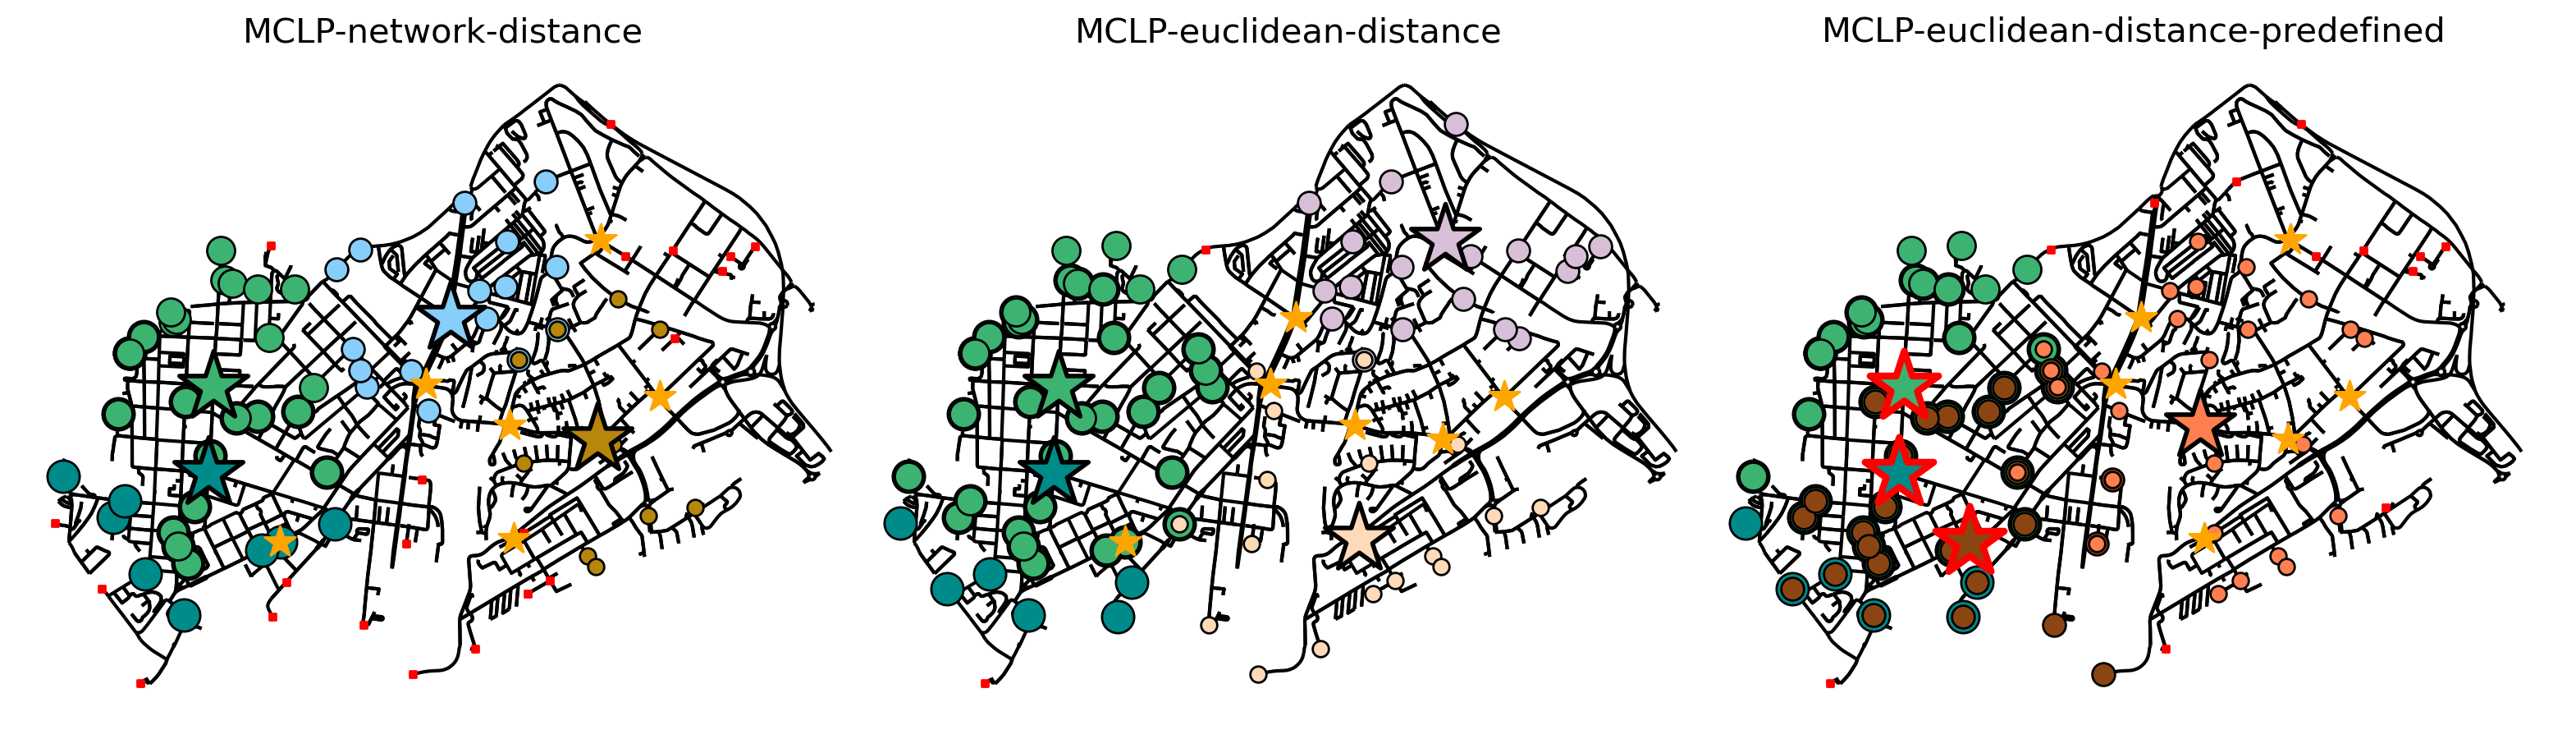

In [42]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([mclp_from_cm, mclp_from_gdf, mclp_from_gdf_pre]):
    plot_results(m, P_FACILITIES, facility_points, clis=client_points, ax=axarr[i])

print(f"{mclp_from_cm.perc_cov}% coverage is observed for MCLP network distance")
print(f"{mclp_from_gdf.perc_cov}% coverage is observed for MCLP euclidean distance")
print(f"{mclp_from_gdf_pre.perc_cov}% coverage is observed for MCLP euclidean distance with forced predefined locations")

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)